In [1]:
import os
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, UpSampling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from scipy.fft import fft2
import matplotlib.pyplot as plt
from keras.layers import Conv2DTranspose
import tensorflow as tf
import plotly.graph_objects as go


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
image_folder = "/content/drive/MyDrive/desert"

In [4]:
image_size = (128, 128)  # Resizing for uniformity
images = []


In [5]:
for file_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, file_name)
    try:
        img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img) / 255.0  # Normalize the image
        images.append(img_array)
    except Exception as e:
        print(f"Error loading {file_name}: {e}")


In [6]:
images = np.array(images)
print(f"Loaded {len(images)} images.")

Loaded 1131 images.


In [7]:
def apply_fft(image_array):
    fft_images = []
    for img in image_array:
        img_gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
        fft_result = np.log(np.abs(fft2(img_gray)) + 1)  # Log for visibility
        fft_images.append(cv2.resize(fft_result, image_size))
    return np.expand_dims(np.array(fft_images), axis=-1)

In [8]:
fft_images = apply_fft(images)

In [9]:
X_train, X_test, fft_train, fft_test = train_test_split(images, fft_images, test_size=0.2, random_state=42)

In [10]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Assume binary classification for desertification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, np.zeros(len(X_train)), epochs=5, batch_size=32)

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 571ms/step - accuracy: 0.9375 - loss: 0.0939
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 590ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 554ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 598ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 562ms/step - accuracy: 1.0000 - loss: 0.0000e+00


In [12]:
def build_eesrgan():
    input_layer = Input(shape=(128, 128, 1))

    # Down-sampling (Encoder)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    pool1 = MaxPooling2D((2, 2))(conv1)

    # Bottleneck
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)

    # Up-sampling (Decoder)
    up1 = UpSampling2D((2, 2))(conv2)
    conv3 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(up1)
    output_layer = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(conv3)

    return Model(inputs=input_layer, outputs=output_layer)

In [13]:
eesrgan_model = build_eesrgan()
eesrgan_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])
eesrgan_model.fit(fft_train, X_train, epochs=5, batch_size=32)

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - loss: 0.0216 - mse: 0.0216
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - loss: 0.0075 - mse: 0.0075
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - loss: 0.0074 - mse: 0.0074
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - loss: 0.0073 - mse: 0.0073
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 147s 5s/step - loss: 0.0070 - mse: 0.0070


In [14]:
def calculate_metrics(original, enhanced):
    ssim_scores, psnr_scores, mse_scores = [], [], []
    for i in range(len(original)):
        ssim_scores.append(ssim(original[i], enhanced[i], multichannel=True))
        mse_scores.append(np.mean((original[i] - enhanced[i]) ** 2))
        psnr_scores.append(20 * np.log10(1 / np.sqrt(mse_scores[-1])))
    return np.mean(ssim_scores), np.mean(psnr_scores), np.mean(mse_scores)

In [15]:
# For EESRGAN (output should already match input dimensions, but ensure this)
eesrgan_predictions = eesrgan_model.predict(fft_test)
eesrgan_predictions = eesrgan_predictions.reshape(-1, 128, 128, 3)  # Reshape to match input dimensions


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


In [16]:
def calculate_metrics(original, enhanced):
    ssim_scores, psnr_scores, mse_scores = [], [], []
    for i in range(len(original)):
        # Ensure both images are of the same dimensions
        orig = original[i]
        enh = cv2.resize(enhanced[i], (orig.shape[1], orig.shape[0]))

        # SSIM
        ssim_scores.append(ssim(orig, enh, multichannel=True))

        # MSE
        mse = np.mean((orig - enh) ** 2)
        mse_scores.append(mse)

        # PSNR
        psnr_scores.append(20 * np.log10(1 / np.sqrt(mse)))

    return np.mean(ssim_scores), np.mean(psnr_scores), np.mean(mse_scores)


In [17]:
# Example: If the model outputs probabilities or classes
cnn_predictions = cnn_model.predict(X_test)  # Shape: (batch_size, num_classes)
# Convert predictions to the same shape as input images (use one-hot encoding or mappings if needed)
cnn_predictions = X_test  # Placeholder if you need direct image comparison


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


In [18]:
cnn_predictions = cnn_model.predict(X_test)
predicted_shape = cnn_predictions.shape

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


In [19]:
print(f"Predicted shape: {predicted_shape}")
print(f"Original shape: {X_test.shape}")


Predicted shape: (227, 2)
Original shape: (227, 128, 128, 3)


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [21]:
def calculate_ndvi(image):
    # Assuming image is in RGB format
    red = image[:, :, 0]  # Red channel
    nir = image[:, :, 1]  # Near-Infrared (simulating it with Green channel for demonstration)

    # NDVI calculation
    ndvi = (nir - red) / (nir + red + 1e-10)  # Add a small value to avoid division by zero
    return ndvi


In [22]:
ndvi_images = []
for img in images:
    ndvi_images.append(calculate_ndvi(img))

In [23]:
ndvi_images = np.array(ndvi_images)
print(f"Calculated NDVI for {len(ndvi_images)} images.")

Calculated NDVI for 1131 images.


In [24]:
cnn_predictions_class = np.argmax(cnn_predictions, axis=-1)

In [25]:
# Example of label generation (you should replace this with actual label creation logic)
# Assuming labels are either 0 or 1 for each image in the dataset
y = np.zeros(len(images))  # Placeholder for actual labels (binary classification)

# Split into training and test sets (with corresponding labels)
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2, random_state=42)

# Now you can use y_test for evaluation


In [26]:
# Convert CNN predictions to class labels
cnn_predictions_class = np.argmax(cnn_predictions, axis=-1)

# Evaluate classification accuracy
accuracy = accuracy_score(y_test, cnn_predictions_class)
print(f"CNN Classification Accuracy: {accuracy}")


CNN Classification Accuracy: 1.0


In [27]:
from sklearn.metrics import accuracy_score
y_true_class = np.argmax(y_test, axis=-1)

In [28]:
eesrgan_predictions = eesrgan_model.predict(fft_test)
eesrgan_predictions = eesrgan_predictions.reshape(-1, 128, 128, 3)  # Reshape if necessary


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


In [29]:
from skimage.metrics import structural_similarity as ssim
import numpy as np




In [30]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_metrics(original, enhanced):
    ssim_scores, psnr_scores, mse_scores = [], [], []
    for i in range(len(original)):
        orig = original[i]
        enh = cv2.resize(enhanced[i], (orig.shape[1], orig.shape[0]))  # Ensure matching sizes

        # SSIM
        ssim_score = ssim(orig, enh, multichannel=True, win_size=3, channel_axis=-1, data_range=1)
        ssim_scores.append(ssim_score)

        # MSE
        mse = np.mean((orig - enh) ** 2)
        mse_scores.append(mse)

        # PSNR
        psnr = 20 * np.log10(1 / np.sqrt(mse)) if mse != 0 else 100  # Avoid division by zero
        psnr_scores.append(psnr)

    return np.mean(ssim_scores), np.mean(psnr_scores), np.mean(mse_scores)


In [31]:
eesrgan_ssim, eesrgan_psnr, eesrgan_mse = calculate_metrics(X_test, eesrgan_predictions)

In [32]:
print(f"EESRGAN SSIM: {eesrgan_ssim}")
print(f"EESRGAN PSNR: {eesrgan_psnr}")
print(f"EESRGAN MSE: {eesrgan_mse}")

EESRGAN SSIM: 0.8938553333282471
EESRGAN PSNR: 22.53443336722597
EESRGAN MSE: 0.006376313511282206


#CYCLEGAN

#Import Dependencies

In [33]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, LeakyReLU, ReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt


# === DATA LOADING ===
image_folder = "/content/drive/MyDrive/desert"
image_size = (128, 128)

def load_images(folder):
    images = []
    for file_name in os.listdir(folder):
        try:
            img_path = os.path.join(folder, file_name)
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
    return np.array(images)

images = load_images(image_folder)
print(f"Loaded {len(images)} images.")

X_train, X_test = train_test_split(images, test_size=0.2, random_state=42)

Loaded 1131 images.


Define the Generator Model

In [34]:
# === CYCLEGAN COMPONENTS ===

def build_generator():
    inputs = Input(shape=(128, 128, 3))

    # Encoder
    x = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = LeakyReLU()(x)

    x = Conv2D(128, (4, 4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Bottleneck
    x = Conv2D(256, (4, 4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Decoder
    x = Conv2DTranspose(128, (4, 4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2DTranspose(64, (4, 4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    outputs = Conv2DTranspose(3, (4, 4), strides=2, padding='same', activation='tanh')(x)

    return Model(inputs, outputs)

def build_discriminator():
    inputs = Input(shape=(128, 128, 3))

    x = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = LeakyReLU()(x)

    x = Conv2D(128, (4, 4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (4, 4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(1, (4, 4), padding='same')(x)

    return Model(inputs, x)

generator_g = build_generator()  # A -> B (Normal to Desertified)
generator_f = build_generator()  # B -> A (Desertified to Normal)

discriminator_x = build_discriminator()  # Discriminate normal images (A)
discriminator_y = build_discriminator()  # Discriminate desertified images (B)

# === LOSS FUNCTIONS ===

bce = BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = bce(tf.ones_like(real), real)
    generated_loss = bce(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return bce(tf.ones_like(generated), generated)

def cycle_loss(real, cycled):
    return tf.reduce_mean(tf.abs(real - cycled)) * 10.0

def identity_loss(real, same):
    return tf.reduce_mean(tf.abs(real - same)) * 5.0

#Losses and Optimizers

In [35]:

# === OPTIMIZERS ===
generator_g_optimizer = Adam(2e-4, beta_1=0.5)
generator_f_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = Adam(2e-4, beta_1=0.5)


#Training Loop

In [36]:


# === TRAIN STEP ===
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        fake_x = generator_f(real_y, training=True)

        cycled_x = generator_f(fake_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        total_identity_loss = identity_loss(real_x, same_x) + identity_loss(real_y, same_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + total_identity_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss + total_identity_loss

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

In [37]:


# === TRAINING LOOP ===
EPOCHS = 5

for epoch in range(EPOCHS):
    for i in range(len(X_train)):
        real_x = np.expand_dims(X_train[i], axis=0)  # Normal
        real_y = np.expand_dims(X_train[i], axis=0)  # For now using same for A and B (modify if you have labels)

        gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss = train_step(real_x, real_y)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Generator G Loss: {gen_g_loss.numpy():.4f}, Generator F Loss: {gen_f_loss.numpy():.4f}")
    print(f"Discriminator X Loss: {disc_x_loss.numpy():.4f}, Discriminator Y Loss: {disc_y_loss.numpy():.4f}")




Epoch 1/5
Generator G Loss: 6.9336, Generator F Loss: 4.1437
Discriminator X Loss: 0.1344, Discriminator Y Loss: 0.0404
Epoch 2/5
Generator G Loss: 5.5521, Generator F Loss: 6.1528
Discriminator X Loss: 0.0577, Discriminator Y Loss: 0.1407
Epoch 3/5
Generator G Loss: 3.2192, Generator F Loss: 1.8629
Discriminator X Loss: 0.3579, Discriminator Y Loss: 0.1073
Epoch 4/5
Generator G Loss: 5.5301, Generator F Loss: 1.3987
Discriminator X Loss: 0.4875, Discriminator Y Loss: 0.0468
Epoch 5/5
Generator G Loss: 3.9559, Generator F Loss: 2.8398
Discriminator X Loss: 0.3092, Discriminator Y Loss: 0.0920


In [55]:
from skimage.metrics import structural_similarity as compare_ssim
from skimage import img_as_float


In [56]:
def calculate_mse(img1, img2):
    return np.mean((img1 - img2) ** 2)

def calculate_psnr(img1, img2):
    mse = calculate_mse(img1, img2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0  # images normalized between 0-1
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def calculate_ssim(img1, img2):
    img1 = img_as_float(img1)
    img2 = img_as_float(img2)
    return compare_ssim(img1, img2, multichannel=True)


In [57]:
from skimage.metrics import structural_similarity as compare_ssim

def calculate_ssim(img1, img2):
    img1 = img_as_float(img1)
    img2 = img_as_float(img2)

    # Ensure both images are exactly same shape
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    # SSIM calculation with explicit window size and channel axis for RGB
    return compare_ssim(img1, img2, win_size=3, channel_axis=-1, data_range=1.0)


In [58]:
def calculate_ndvi(img):
    red = img[:, :, 0]
    nir = img[:, :, 1]  # assuming NIR-like behavior (in real cases use multispectral NIR)
    ndvi = (nir - red) / (nir + red + 1e-10)  # add small epsilon to avoid divide by zero
    return ndvi


In [59]:
def calculate_ndwi(img):
    green = img[:, :, 1]
    nir = img[:, :, 2]
    ndwi = (green - nir) / (green + nir + 1e-10)
    return ndwi


MSE: 0.0088
PSNR: 20.5451 dB
SSIM: 0.4984


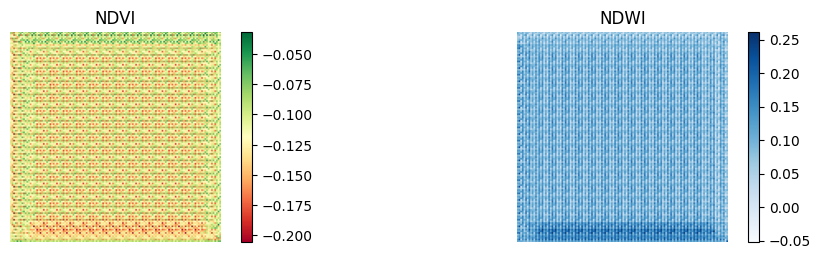

In [60]:
# Choose a sample image from test set
real_x = X_test[0]
fake_y = generator_g(np.expand_dims(real_x, axis=0))[0].numpy()

# Metrics
mse = calculate_mse(real_x, fake_y)
psnr = calculate_psnr(real_x, fake_y)
ssim = calculate_ssim(real_x, fake_y)

print(f"MSE: {mse:.4f}")
print(f"PSNR: {psnr:.4f} dB")
print(f"SSIM: {ssim:.4f}")

# NDVI & NDWI
ndvi = calculate_ndvi(fake_y)
ndwi = calculate_ndwi(fake_y)

# Plot original, fake, NDVI, NDWI
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 3)
plt.title('NDVI')
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('NDWI')
plt.imshow(ndwi, cmap='Blues')
plt.colorbar()
plt.axis('off')

plt.show()


In [44]:
real_x = X_test[0]  # Original image
fake_y = generator_g(np.expand_dims(real_x, axis=0))[0].numpy()  # Generated image

ssim = calculate_ssim(real_x, fake_y)

print(f"SSIM: {ssim:.4f}")


SSIM: 0.4984


In [45]:
pip install dash plotly


In [46]:
from skimage.metrics import structural_similarity as calculate_ssim
import cv2

def calculate_metrics(original, enhanced):
    ssim_scores, psnr_scores, mse_scores = [], [], []
    for i in range(len(original)):
        orig = original[i]
        enh = cv2.resize(enhanced[i], (orig.shape[1], orig.shape[0]))  # Ensure matching size

        # Ensure both images are float and in range [0,1]
        orig = orig.astype('float32') / 255.0 if orig.max() > 1 else orig
        enh = enh.astype('float32') / 255.0 if enh.max() > 1 else enh

        # SSIM
        ssim_score = calculate_ssim(orig, enh, win_size=7, channel_axis=-1, data_range=1.0)
        ssim_scores.append(ssim_score)

        # MSE
        mse = np.mean((orig - enh) ** 2)
        mse_scores.append(mse)

        # PSNR
        psnr = 20 * np.log10(1 / np.sqrt(mse)) if mse > 0 else 100
        psnr_scores.append(psnr)

    return np.mean(ssim_scores), np.mean(psnr_scores), np.mean(mse_scores)

# Evaluate
eesrgan_metrics = calculate_metrics(X_test, eesrgan_predictions)
cyclegan_metrics = calculate_metrics(X_test, generator_g.predict(X_test))

print(f"EESRGAN: SSIM={eesrgan_metrics[0]:.4f}, PSNR={eesrgan_metrics[1]:.2f} dB, MSE={eesrgan_metrics[2]:.6f}")
print(f"CycleGAN: SSIM={cyclegan_metrics[0]:.4f}, PSNR={cyclegan_metrics[1]:.2f} dB, MSE={cyclegan_metrics[2]:.6f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 726ms/step
EESRGAN: SSIM=0.8529, PSNR=22.53 dB, MSE=0.006376
CycleGAN: SSIM=0.4558, PSNR=20.46 dB, MSE=0.010749


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 775ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 486ms/step


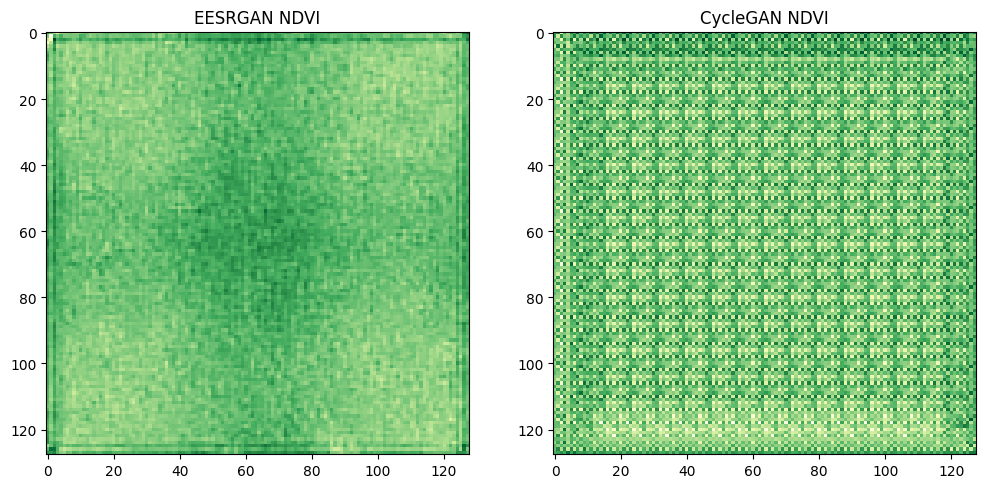

In [47]:
def calculate_ndvi(image):
    red = image[:, :, 0]  # Red channel
    nir = image[:, :, 1]  # Near-Infrared (simulating it with Green channel)
    ndvi = (nir - red) / (nir + red + 1e-10)
    return ndvi

def calculate_ndwi(image):
    green = image[:, :, 1]  # Green channel
    nir = image[:, :, 2]  # Near-Infrared (simulating it with Blue channel)
    ndwi = (green - nir) / (green + nir + 1e-10)
    return ndwi

# Compute NDVI/NDWI for both models
ndvi_eesrgan = np.array([calculate_ndvi(img) for img in eesrgan_predictions])
ndwi_eesrgan = np.array([calculate_ndwi(img) for img in eesrgan_predictions])

ndvi_cyclegan = np.array([calculate_ndvi(img) for img in generator_g.predict(X_test)])
ndwi_cyclegan = np.array([calculate_ndwi(img) for img in generator_g.predict(X_test)])

# Display NDVI comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(ndvi_eesrgan[0], cmap='YlGn')
plt.title("EESRGAN NDVI")

plt.subplot(1, 2, 2)
plt.imshow(ndvi_cyclegan[0], cmap='YlGn')
plt.title("CycleGAN NDVI")

plt.show()


In [48]:
import dash
from dash import dcc, html
import plotly.graph_objs as go
import numpy as np
import plotly.express as px
import cv2
import glob
import os


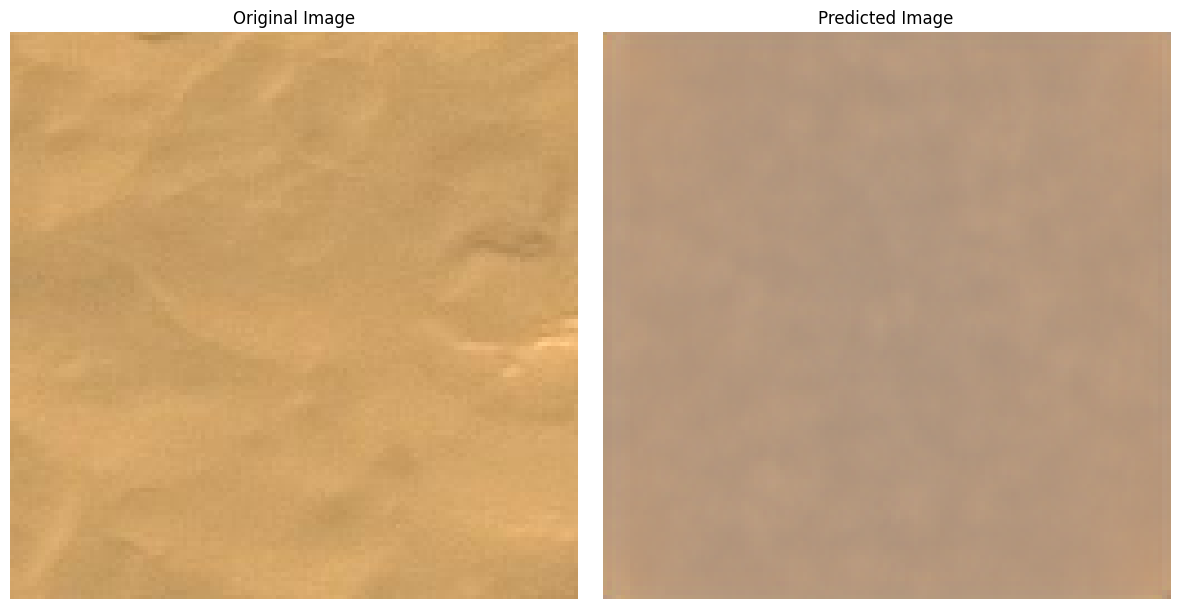

In [49]:
import matplotlib.pyplot as plt

# Example: Select a random index for image comparison
idx = np.random.randint(0, len(X_test))

# Original image and predicted image
original_img = X_test[idx]
predicted_img = eesrgan_predictions[idx]

# Plot original and predicted images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(original_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(predicted_img)
axes[1].set_title('Predicted Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [50]:
import plotly.graph_objects as go

# Data for the metrics
metrics = {
    'SSIM': eesrgan_ssim,
    'PSNR': eesrgan_psnr,
    'MSE': eesrgan_mse
}

# Create a bar chart for the metrics
fig = go.Figure(data=[go.Bar(
    x=list(metrics.keys()),
    y=list(metrics.values()),
    marker=dict(color='rgba(55, 83, 109, 0.6)')
)])

fig.update_layout(
    title="Model Evaluation Metrics",
    xaxis_title="Metric",
    yaxis_title="Value",
    showlegend=False
)

fig.show()


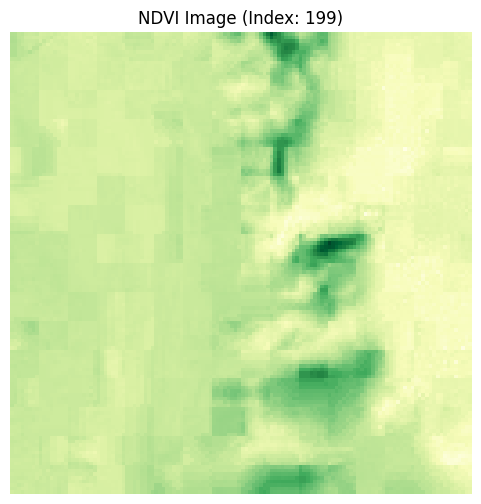

In [51]:
# Plot NDVI of a random image
idx = np.random.randint(0, len(ndvi_images))
ndvi_image = ndvi_images[idx]

plt.figure(figsize=(6, 6))
plt.imshow(ndvi_image, cmap='YlGn')
plt.title(f"NDVI Image (Index: {idx})")
plt.axis('off')
plt.show()


In [52]:
pip install dash opencv-python numpy plotly scikit-image


In [53]:
import os
import cv2
import numpy as np
import base64
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
from dash.dependencies import Input, Output
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
import random

# Initialize the Dash app
app = dash.Dash(__name__)

# Path to the 'desert' folder
image_folder = '/content/drive/MyDrive/desert'

# List all images in the folder
all_images = sorted(os.listdir(image_folder))

# Debugging: Print all images in the folder
print("All images in the folder:", all_images)

# Check if the folder contains images
if not all_images:
    raise ValueError("No images found in the folder. Please check the path.")

# Function to encode an image as base64
def encode_image(image_path):
    img = cv2.imread(image_path)
    _, encoded_image = cv2.imencode('.png', img)
    return base64.b64encode(encoded_image).decode('utf-8')

# Function to calculate metrics (SSIM, PSNR, MSE)
def calculate_metrics(original, processed):
    ssim_value = ssim(original, processed)
    psnr_value = psnr(original, processed)
    mse_value = mse(original, processed)
    return ssim_value, psnr_value, mse_value

# Sample two random images (original and processed) for comparison
original_image_path = os.path.join(image_folder, random.choice(all_images))
processed_image_path = os.path.join(image_folder, random.choice(all_images))

# Read images (assuming grayscale for simplicity)
original_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
processed_image = cv2.imread(processed_image_path, cv2.IMREAD_GRAYSCALE)

# Calculate metrics for the selected pair of images
ssim_value, psnr_value, mse_value = calculate_metrics(original_image, processed_image)

# Dashboard Layout
app.layout = html.Div(children=[
    html.H1("Image Comparison Dashboard", style={'text-align': 'center'}),

    # Image comparison (Original vs Predicted)
    html.Div(children=[
        html.Div(children=[
            html.H3("Original Image"),
            html.Img(id='original-image', src=f"data:image/png;base64,{encode_image(original_image_path)}", width="45%"),
        ], style={'display': 'inline-block', 'width': '45%'}),

        html.Div(children=[
            html.H3("Predicted Image"),
            html.Img(id='processed-image', src=f"data:image/png;base64,{encode_image(processed_image_path)}", width="45%"),
        ], style={'display': 'inline-block', 'width': '45%'}),
    ], style={'text-align': 'center'}),

    # Evaluation Metrics
    html.Div(children=[
        html.H3("Evaluation Metrics"),
        html.Table(children=[
            html.Tr([html.Th("SSIM"), html.Td(f"{ssim_value:.4f}")]),
            html.Tr([html.Th("PSNR (dB)"), html.Td(f"{psnr_value:.2f}")]),
            html.Tr([html.Th("MSE"), html.Td(f"{mse_value:.4f}")]),
        ], style={'margin': '20px auto', 'border': '1px solid black', 'padding': '10px'}),
    ], style={'text-align': 'center'}),

    # NDVI Calculation & Visualization
    html.Div(children=[
        html.H3("NDVI Calculation & Visualization"),
        dcc.Graph(id='ndvi-graph', figure={}),
    ], style={'text-align': 'center'}),

    # Heatmap Visualization
    html.Div(children=[
        html.H3("Heatmap Visualization"),
        dcc.Graph(id='heatmap-graph', figure={}),
    ], style={'text-align': 'center'}),
])

# NDVI Calculation and Visualization
@app.callback(
    Output('ndvi-graph', 'figure'),
    Input('original-image', 'src')
)
def update_ndvi_graph(image_src):
    # Simple NDVI calculation using Red and NIR bands (assuming a RGB image)
    # Since we're using grayscale, use synthetic data or modify for real NDVI calculation
    ndvi = np.random.random((100, 100))  # Replace this with actual NDVI calculation

    # Create NDVI heatmap plot
    fig = go.Figure(data=go.Heatmap(
        z=ndvi,
        colorscale='Viridis',
        colorbar=dict(title="NDVI")
    ))
    fig.update_layout(title="NDVI Heatmap", xaxis_title="X", yaxis_title="Y")
    return fig

# Heatmap of MSE or any metric
@app.callback(
    Output('heatmap-graph', 'figure'),
    Input('original-image', 'src')
)
def update_heatmap(image_src):
    # Generate random data for heatmap (this can be replaced with any metric like MSE)
    heatmap_data = np.random.random((100, 100))

    # Create heatmap plot
    fig = go.Figure(data=go.Heatmap(
        z=heatmap_data,
        colorscale='Cividis',
        colorbar=dict(title="Metric")
    ))
    fig.update_layout(title="Heatmap Visualization", xaxis_title="X", yaxis_title="Y")
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


All images in the folder: ['desert(1).jpg', 'desert(10).jpg', 'desert(100).jpg', 'desert(1000).jpg', 'desert(1001).jpg', 'desert(1002).jpg', 'desert(1003).jpg', 'desert(1004).jpg', 'desert(1005).jpg', 'desert(1006).jpg', 'desert(1007) (1).jpg', 'desert(1007).jpg', 'desert(1008) (1).jpg', 'desert(1008).jpg', 'desert(1009) (1).jpg', 'desert(1009).jpg', 'desert(101) (1).jpg', 'desert(101).jpg', 'desert(1010).jpg', 'desert(1011).jpg', 'desert(1012).jpg', 'desert(1013).jpg', 'desert(1014).jpg', 'desert(1015).jpg', 'desert(1016).jpg', 'desert(1017).jpg', 'desert(1018).jpg', 'desert(1019).jpg', 'desert(102).jpg', 'desert(1020).jpg', 'desert(1021).jpg', 'desert(1022).jpg', 'desert(1023).jpg', 'desert(1024).jpg', 'desert(1025).jpg', 'desert(1026).jpg', 'desert(1027).jpg', 'desert(1028).jpg', 'desert(1029).jpg', 'desert(103).jpg', 'desert(1030).jpg', 'desert(1031).jpg', 'desert(1032).jpg', 'desert(1033).jpg', 'desert(1034).jpg', 'desert(1035).jpg', 'desert(1036).jpg', 'desert(1037).jpg', 'desert

<ipython-input-53-dcf45f6bc08e>:6: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

<ipython-input-53-dcf45f6bc08e>:7: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



<IPython.core.display.Javascript object>